In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


import pandas as pd
import numpy as np
import warnings
import sys
import pickle

In [9]:
# suppressing warning messages

warnings.filterwarnings('ignore')

In [10]:
# importing scripts

sys.path.insert(1, '../scripts')

from data_viz import Data_Viz
from data_cleaning import DataCleaner
from data_transformation import DataTransformer

DV = Data_Viz("../logs/data_model_notebook.log")
DC = DataCleaner("../logs/data_model_notebook.log")
DT = DataTransformer("../logs/data_model_notebook.log")

In [11]:
# importing the data

train = pd.read_csv("../data/train_store.csv")

In [12]:
# selecting out some features

train_cl = train.drop(["Customers"], axis=1)
sales = train_cl.pop("Sales")
train_cl.insert(0,"Sales", sales)
train_cl.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 23 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Sales                1017209 non-null  float64
 1   Store                1017209 non-null  int64  
 2   DayOfWeek            1017209 non-null  int64  
 3   Date                 1017209 non-null  object 
 4   Open                 1017209 non-null  int64  
 5   Promo                1017209 non-null  int64  
 6   StateHoliday         1017209 non-null  object 
 7   SchoolHoliday        1017209 non-null  int64  
 8   StoreType            1017209 non-null  object 
 9   Assortment           1017209 non-null  object 
 10  CompetitionDistance  1017209 non-null  float64
 11  Promo2               1017209 non-null  int64  
 12  Promo2SinceWeek      1017209 non-null  float64
 13  Promo2SinceYear      1017209 non-null  float64
 14  PromoInterval        1017209 non-null  object 
 15

In [13]:
# separating numerical and categorical variables

categorical_lis, numerical_lis = DT.sep_cat_num(train_cl)
categorical_lis.head()

,Date,StateHoliday,StoreType,Assortment,PromoInterval
0,2015-07-31,No Holiday,c,a,Not_Av
1,2015-07-31,No Holiday,a,a,"Jan,Apr,Jul,Oct"
2,2015-07-31,No Holiday,a,a,"Jan,Apr,Jul,Oct"
3,2015-07-31,No Holiday,c,c,Not_Av
4,2015-07-31,No Holiday,a,a,Not_Av


In [14]:
# setup pipeline

sampled_train_cl = train_cl.sample(n=100000)
sets = DT.build_pipe(categorical_lis.columns.to_list()).fit_transform(sampled_train_cl)

catagories successfully labeled
Data successfully scaled
target and features separated
data successfully splitted


In [15]:
# fitting data using Random Forest Regressor

model = RandomForestRegressor(n_estimators = 100, random_state = 0)
 
# fit the regressor with x and y data
model.fit(sets[0], sets[1]) 

RandomForestRegressor(random_state=0)

### Loss functions

- MAE = Mean Absolute Eror. this is robhust when outliers are present in the data. 
- MSE = Mean Squared Eror. This function penalizes large errors and it is easiy to calculate gradients.

Since there are no outliers in the data, MSE is chosen.



In [16]:
# checking accuracy

accuracy = model.score(sets[2], sets[3])
print("prediction accuracy: ", accuracy)

prediction accuracy:  0.8801434347310003


### calculating feature importance

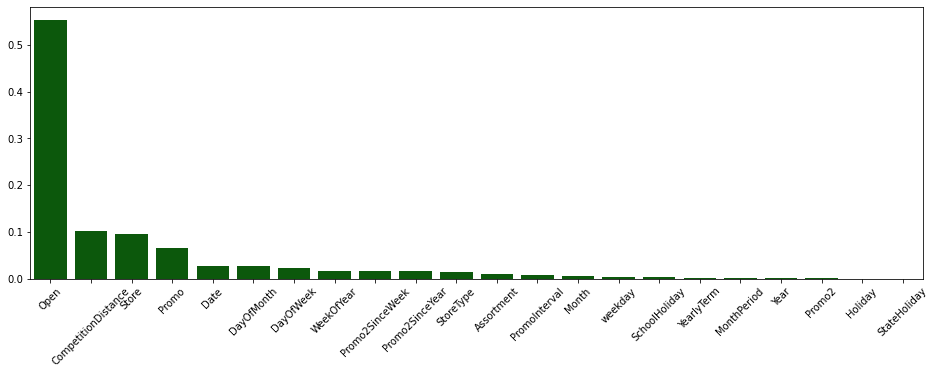

In [38]:
#features, target= DT.target_feature(train_cl, 0)

imp_dict = DV.get_importance(model, train_cl)
features = list(imp_dict.keys())
importance = list(imp_dict.values())
plt.figure(figsize=(16,5))
pal = sns.color_palette("flare", as_cmap=True)
ax = sns.barplot(features, importance, color="darkgreen")
ax.invert_xaxis()
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

In [19]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(sets[4], sets[5])
print(result)

IndexError: list index out of range

## reducing number of features

In [41]:
## Removing irrelevant features and cusomer
include_list = ["Sales", 'Month', 'PromoInterval', 'Assortment', 'StoreType','WeekOfYear', 'DayOfWeek', 'DayOfMonth', 'Promo', 'Store', 'CompetitionDistance', 'Open']
train_2 = train_cl[include_list]
train_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Sales                1017209 non-null  float64
 1   Month                1017209 non-null  int64  
 2   PromoInterval        1017209 non-null  object 
 3   Assortment           1017209 non-null  object 
 4   StoreType            1017209 non-null  object 
 5   WeekOfYear           1017209 non-null  int64  
 6   DayOfWeek            1017209 non-null  int64  
 7   DayOfMonth           1017209 non-null  int64  
 8   Promo                1017209 non-null  int64  
 9   Store                1017209 non-null  int64  
 10  CompetitionDistance  1017209 non-null  float64
 11  Open                 1017209 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 93.1+ MB


In [42]:
# separating numerical and categorical variables

categorical_lis2, numerical_lis2 = DT.sep_cat_num(train_2)

sampled_train_cl2 = train_2.sample(n=100000)
sets2 = DT.build_pipe(categorical_lis2.columns.to_list()).fit_transform(sampled_train_cl2)

# fitting data using Random Forest Regressor
model2 = RandomForestRegressor(n_estimators = 100, random_state = 0)
 
# fit the regressor with x and y data
model2.fit(sets2[0], sets2[1])

# checking accuracy
accuracy2 = model2.score(sets2[2], sets2[3])
print("prediction accuracy: ", accuracy2)


catagories successfully labeled
Data successfully scaled
target and features separated
data successfully splitted
prediction accuracy:  0.8769984865067956


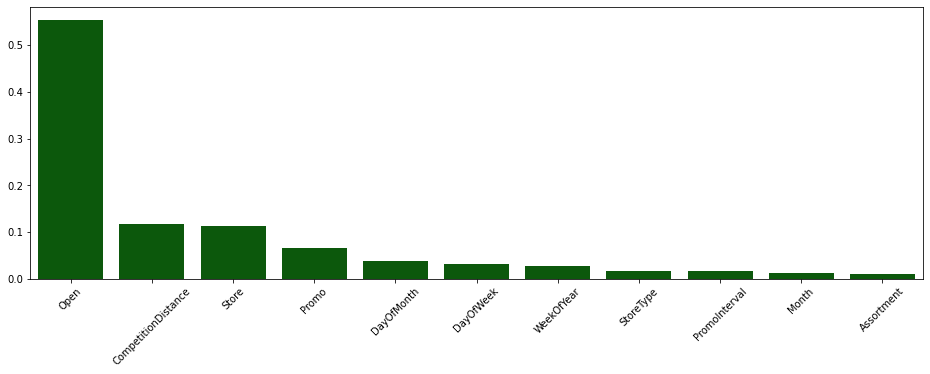

In [43]:
#features, target= DT.target_feature(train_cl, 0)
imp_dict = DV.get_importance(model2, train_2)
features = list(imp_dict.keys())
importance = list(imp_dict.values())
plt.figure(figsize=(16,5))
pal = sns.color_palette("flare", as_cmap=True)
ax = sns.barplot(features, importance, color="darkgreen")
ax.invert_xaxis()
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

In [40]:
# datetime object containing current date and time
now = datetime.now()
time = now.strftime("%d-%m-%Y-%H-%M-%S")
filename = "../models/RFR-sales-"+str(time)+'.pkl'
pickle.dump(model2, open(filename, 'wb'))

In [ ]:
## Predicting number of customers
